<a href="https://colab.research.google.com/github/chetan015/deep-learning/blob/master/Assignment-07/Assignment-07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import Model
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf




Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

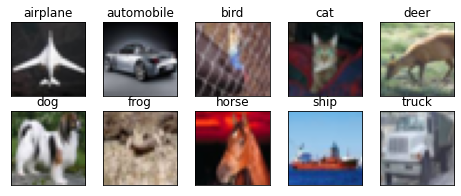

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

![alt text](https://2.bp.blogspot.com/-HQo2Kx39Q6A/WsqZQn5pJHI/AAAAAAAAVhY/FBkgOeS06vQNvZN2KI2hhGZmfS1cNPg8wCLcBGAs/s1600/enasdiscoverednetwork.png)

In [0]:
def space_to_depth_x2(x):
    return tf.nn.space_to_depth(x, block_size=2)

In [0]:
from keras.layers import Input, Conv2D, SeparableConv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, concatenate,merge,Add, Lambda

In [0]:
model_input = Input(shape=(32,32,3))
# Layer 1 5x5 separable convolution
layer1 = SeparableConv2D(32,5,5,border_mode='same',activation='relu', name="layer1_5x5_Sep")(model_input)
layer1 = BatchNormalization(name='norm_1')(layer1)

# layer 2 5x5 convolution
layer2 = Conv2D(32,5,5,border_mode='same',activation='relu',name="layer2_5x5")(layer1)
layer2 = BatchNormalization(name='norm_2')(layer2)
# layer 3 5x5 convolution
layer3 = Conv2D(32,5,5,border_mode='same',activation='relu',name="layer3_5x5")(layer2)
layer3 = BatchNormalization(name='norm_3')(layer3)
# Merge Layer3 and Layer1 output and feed to Layer4
merge1_3 = concatenate([layer1,layer3])

# Layer 4 5x5 separable convolution
layer4 = SeparableConv2D(32,5,5,border_mode='same',activation='relu',name="layer4_5x5_sep")(merge1_3)
layer4 = BatchNormalization(name='norm_4')(layer4)
# Merge Layer4 and Layer1 output and feed to maxpool
merge1_4 = concatenate([layer1,layer4])
maxpool1 = MaxPooling2D(pool_size=2,name="maxpool1")(merge1_4)

# Layer 5 3x3 separable convolution
layer5 = SeparableConv2D(32,3,3,border_mode='same',activation='relu',name="layer5_3x3_sep")(maxpool1)
layer5 = BatchNormalization(name='norm_5')(layer5)
# Merge 1,4 and 5 and feed to Layer 6 
# Convert layer1, layer4 output of width and height 32x32 to 16x16
std1 = Lambda(space_to_depth_x2)(layer1)
std2 = Lambda(space_to_depth_x2)(layer2)
std3 = Lambda(space_to_depth_x2)(layer3)
std4 =  Lambda(space_to_depth_x2)(layer4)
merge_1_4_5 = concatenate([std1,std4,layer5])

# Layer 6 5x5 convolution

layer6 = Conv2D(32,5,5, border_mode='same',activation='relu',name="layer6_5x5")(merge_1_4_5)
layer6 = BatchNormalization(name='norm_6')(layer6)
std6 =  Lambda(space_to_depth_x2)(layer6)

# Merge 3,4 5 and 6 and feed to Layer 7
merge3_4_5_6 = concatenate([std3,std4,layer5,layer6])

# Layer 7 3x3 separable convolution
layer7 = Conv2D(32,3,3,border_mode='same',activation='relu',name="layer7_3x3_sep")(merge3_4_5_6)
layer7 = BatchNormalization(name='norm_7')(layer7)
# Merge Layers 7,6,3,5,1,4 output and feed to Layer 8
merge1_3_4_5_6_7 = concatenate([std1,std3,std4,layer5,layer6,layer7])

# Layer 8 5x5 separable convolution
layer8 = Conv2D(32,5,5,border_mode='same',activation='relu',name="layer8_5x5_sep")(merge1_3_4_5_6_7) 
layer8 = BatchNormalization(name='norm_8')(layer8)
# Maxpool on merged outputs from layers 1,4,5,7, 8
merge1_4_5_7_8 = concatenate([std1,std4,layer5,layer7,layer8])
maxpool2 = MaxPooling2D(pool_size=2,name="maxpool2")(merge1_4_5_7_8)

# Merge maxpool2, layer 6 and feed to Layer 9
merge_6_mp2 = concatenate([std6,maxpool2])

# Layer 9 5x5 convolution
layer9 = Conv2D(32,5,5, border_mode='same',activation='relu',name="layer9_5x5")(merge_6_mp2)
layer9 = BatchNormalization(name='norm_9')(layer9)

std1_2 = Lambda(space_to_depth_x2)(std1)
std2_2 = Lambda(space_to_depth_x2)(std2)
std3_2 = Lambda(space_to_depth_x2)(std3)
std4_2 = Lambda(space_to_depth_x2)(std4)

std5 = Lambda(space_to_depth_x2)(layer5)
std7 = Lambda(space_to_depth_x2)(layer7)

# Merge layers 9,7,2,5 and feed to Layer 10
merge2_5_7_9 = concatenate([std2_2,std5,std7,layer9])

# Layer 10 5x5 separable convolution
layer10 = SeparableConv2D(32,5,5,border_mode='same',activation='relu',name="layer10_5x5_sep")(merge2_5_7_9) 
layer10 = BatchNormalization(name='norm_10')(layer10)

# Merge layers 2,3,5,9,10 and feed to layer11
merge2_3_5_9_10 = concatenate([std2_2,std3_2,std5,layer9,layer10])

# Layer 11 3x3 convolution
layer11 = Conv2D(32,3,3,border_mode='same',activation='relu',name="layer11_3x3")(merge2_3_5_9_10)
layer11 = BatchNormalization(name='norm_11')(layer11)

# Merge layers 1,3,4,5,7,10,11 and feed to layer12
merge1_3_4_5_7_10_11 = concatenate([std1_2,std3_2,std4_2,std5,std7,layer10,layer11])

# Layer 12 5x5 separable convolution
layer12 = Conv2D(32,5,5,border_mode='same',activation='relu',name="layer12_5x5_sep")(merge1_3_4_5_7_10_11)
layer12 = BatchNormalization(name='norm_12')(layer12)

# Now we have 32x8x8
# Reduce to ten channels
layer13 = Conv2D(10,1,name="layer13_1x1")(layer12)
# Add final convolution to reshape output layer to 1x10
layer14 = Conv2D(10,8,8,name="layer14_8x8")(layer13)
layer14 = Flatten(name="flatten")(layer14)
output = Activation('softmax',name="softmax")(layer14)

model = Model(model_input,output)





model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Learning Rate scheduler to find optimal learning rate
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  return round(0.006 * 1/(1 + 0.319 * epoch), 10)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, (5, 5), activation="relu", name="layer1_5x5_Sep", padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", name="layer2_5x5", padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", name="layer3_5x5", padding="same")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, (5, 5), activation="relu", name="layer4_5x5_sep", padding="same")`
  app.launch_

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
layer1_5x5_Sep (SeparableConv2D (None, 32, 32, 32)   203         input_8[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 32, 32, 32)   128         layer1_5x5_Sep[0][0]             
__________________________________________________________________________________________________
layer2_5x5 (Conv2D)             (None, 32, 32, 32)   25632       norm_1[0][0]                     
____________________________________________________________________________________________

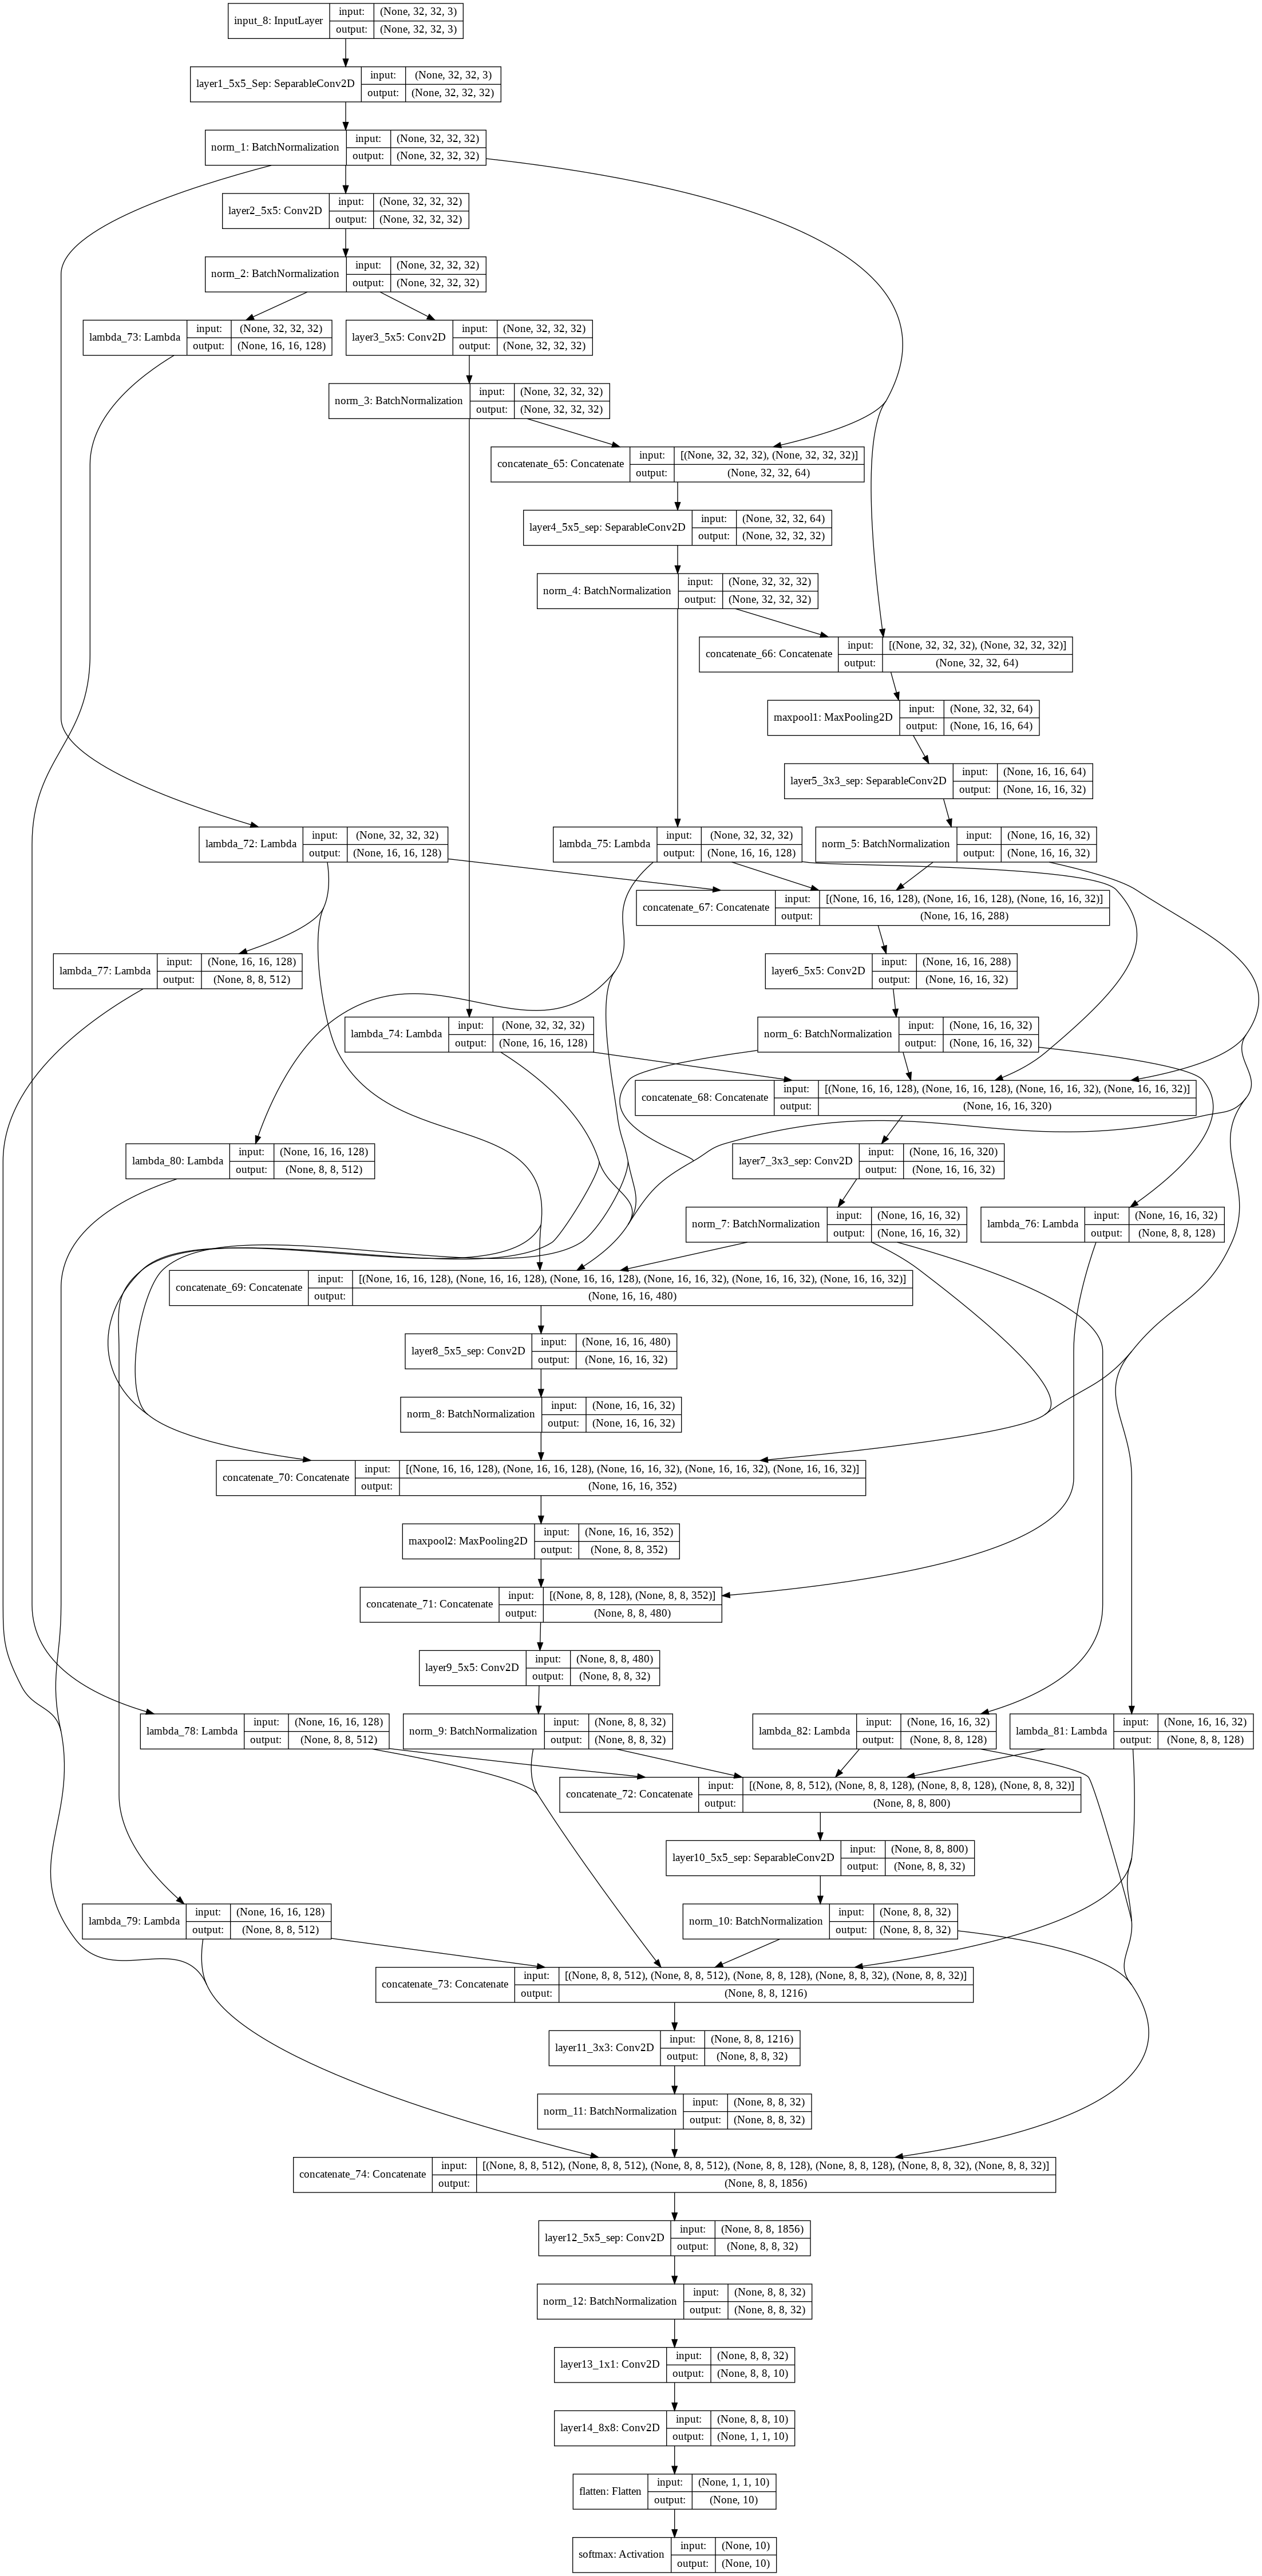

In [0]:
from keras.utils import plot_model
model.summary()
plot_model(model, 'model.png', show_shapes=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.006.
390/390 [==============================] - 74s 189ms/step - loss: 1.4479 - accuracy: 0.4847 - val_loss: 2.2842 - val_accuracy: 0.2791
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0045489007.
390/390 [==============================] - 70s 180ms/step - loss: 0.9715 - accuracy: 0.6555 - val_loss: 1.0943 - val_accuracy: 0.6275
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0036630037.
390/390 [==============================] - 70s 180ms/step - loss: 0.7370 - accuracy: 0.7414 - val_loss: 0.8927 - val_accuracy: 0.6955
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0030659172.
390/390 [==============================] - 70s 179ms/step - loss: 0.5714 - accuracy: 0.8005 - val_loss: 0.9530 - val_accuracy: 0.6855
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.0026362039.
390/390 [==============================] 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


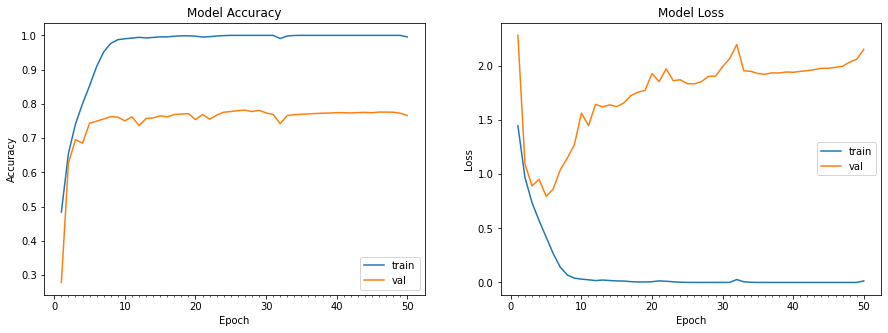

Accuracy on test data is: 76.61


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1,callbacks=[LearningRateScheduler(scheduler, verbose=1)])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))